In [6]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/kaggle/input/turkish-movie-sentiment-analysis-dataset/turkish_movie_sentiment_dataset.csv'
df = pd.read_csv(file_path)

df.dropna(subset=['comment', 'film_name', 'point'], inplace=True)
df['comment'] = df['comment'].str.strip().replace(r'\n|\r', ' ', regex=True)
df['point'] = df['point'].str.replace(',', '.').astype(float)


**pandas** kullanarak veri kümesini CSV dosyasından yükledim.
*   dropna(): Boş değerler içeren satırları kaldırdım.
*   str.strip() ve str.replace(): Yorumların etrafındaki boşlukları temizledim ve satır/karakter değişimlerini yaptım.
*   str.replace(',', '.'): Virgülleri noktaya çevirdim ve puanları float türüne dönüştürdüm.

# Veri Ön İşleme 1

In [7]:
def point_to_label(point):
    if point >= 4:
        return 'positive'
    elif point >= 2:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['point'].apply(point_to_label)
le_film = LabelEncoder()
le_sentiment = LabelEncoder()
df['film_name'] = le_film.fit_transform(df['film_name'])
df['sentiment'] = le_sentiment.fit_transform(df['sentiment'])

Puanlara göre yorumları positive, neutral, veya negative olarak etiketledim.
* **Kategorik Verileri Kodlama:** LabelEncoder kullanarak *film_name* ve *sentiment* kolonlarını sayısal değerlere dönüştürdüm.

In [8]:
scaler = MinMaxScaler()
df[['point']] = scaler.fit_transform(df[['point']])

**MinMaxScaler** kullanarak puanları 0 ile 1 arasına ölçekledim. Bu, modelin farklı veri ölçeklerine daha iyi uyum sağlamasına yardımcı olacak.

# Keşifsel Veri Analizi (EDA)

In [9]:
print("Veri Seti Başlığı ve İlk 5 Satır:")
print(df.head())

print("\nVeri Seti Bilgileri:")
print(df.info())

print("\nVeri Seti Özeti:")
print(df.describe())

Veri Seti Başlığı ve İlk 5 Satır:
                                             comment  film_name  point  \
0  Jean Reno denince zaten leon filmi gelir akla ...       5467    1.0   
1  Ekşın falan izlemek istiyorsanız eğer bunu izl...       5467    1.0   
2  Bu yapım hakkında öyle çok şey yazabilirim ki ...       5467    1.0   
3  finali yeter... (sting - shape of my heart)   ...       5467    1.0   
4  Jean Reno..  bu adam kusursuz biri..  ve oyunc...       5467    1.0   

   sentiment  
0          2  
1          2  
2          2  
3          2  
4          2  

Veri Seti Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83227 entries, 0 to 83226
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   comment    83227 non-null  object 
 1   film_name  83227 non-null  int64  
 2   point      83227 non-null  float64
 3   sentiment  83227 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.5+ MB


*   **df.head()** ile veri setinin ilk 5 satırı gösterdim, böylece her sütunun nasıl göründüğü ve ilk birkaç veri satırı hakkında bilgi almış oldum.
*   **df.info()** ile veri setindeki her sütunun tipi ( int, float, object), boş değerlerin olup olmadığı ve toplam satır sayısını gösterdim. Bu, verinin yapısı ve eksiklikleri hakkında genel bir fikir vermiş oldum.
*  **df.describe()** ile sayısal sütunların özet istatistiklerini (ortalama, standart sapma, minimum, maksimum...) gösterdim, böylece verinin dağılımı hakkında bilgi edinmiş oldum.



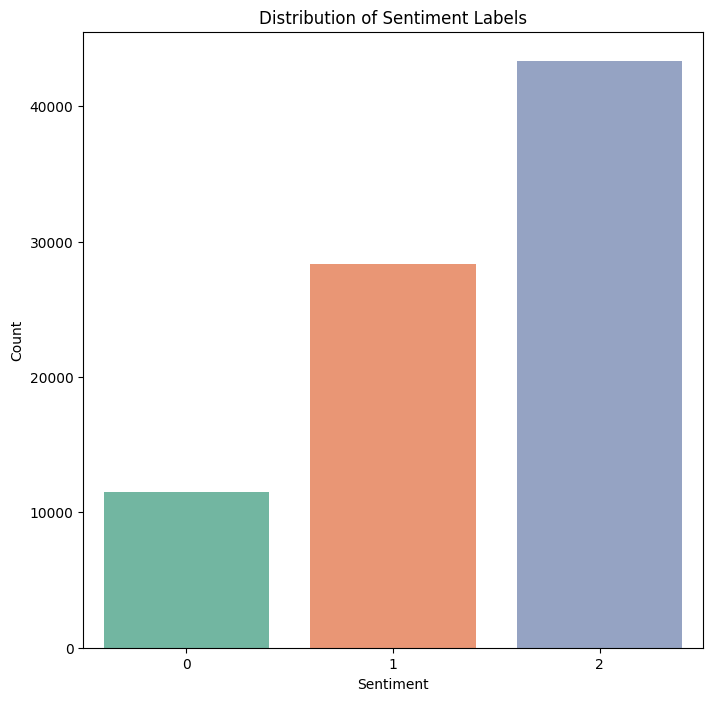

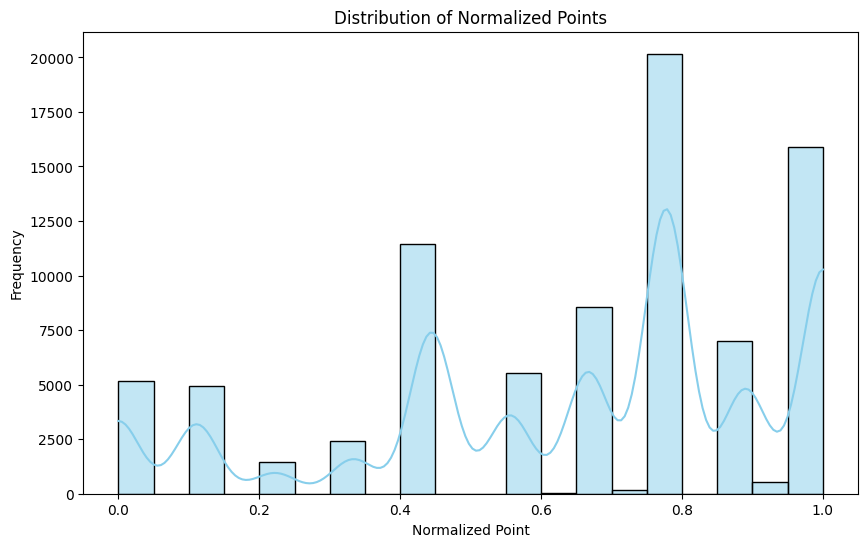

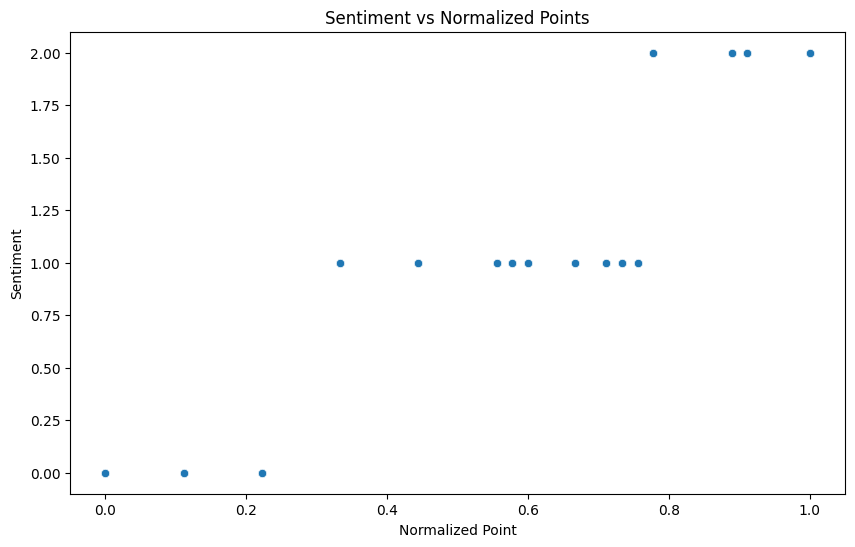

In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)
df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

plt.figure(figsize=(8, 8))
sentiment_counts = df['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['point'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Normalized Points')
plt.xlabel('Normalized Point')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='point', y='sentiment', data=df)
plt.title('Sentiment vs Normalized Points')
plt.xlabel('Normalized Point')
plt.ylabel('Sentiment')
plt.show()

*   **df['sentiment'].value_counts()** ile her duygu etiketinin (pozitif, negatif, nötr) sayısını hesapladım ve çubuk grafikle gösterdim.
*   **df['point']** verisinin dağılımını 20 bölmeye ayırdım ve histogram olarak gösterdim. Ayrıca, **kde=True** ile dağılımın yoğunluğunu çizgiyle gösterdim.
*   Normalleştirilmiş puanlar ile duygu etiketleri arasındaki ilişkiyi bir dağılım grafiği (scatter plot) ile görselleştirdim.

# Veri Ön İşleme 2

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_comments = tfidf_vectorizer.fit_transform(df['comment']).toarray()

pca = PCA(n_components=100)
X_comments_pca = pca.fit_transform(X_comments)

**Metni Sayısallaştırma:** Makine öğrenimi algoritmaları sayısal verilerle çalışır. Yorumları TF-IDF ile vektörleştirerek, metni sayısal vektörlere dönüştürerek model için anlamlı hale getirdim.

**Boyut Azaltma:** TF-IDF ile oluşturulan 1000 boyutlu vektörler, veri aşırı yüklenmesine ve daha uzun işlem sürelerine yol açabileceği için *PCA (Principal Component Analysis)* ile bu boyutları 100’e indirgedim. Bu sayede, daha hızlı ve hafif bir model elde ettim. Ayrıca, PCA modelin aşırı öğrenmesinin de önüne geçer ve genel performansını artırır.

In [12]:
X_other = df[['point', 'film_name']].values
X = np.hstack((X_comments_pca, X_other))


*TF-IDF* özelliklerini ve diğer özellikleri birleştirerek tam özellik setini oluşturdum. Hem metin hem de sayısal özellikleri modelleme için hazırladım.

In [13]:
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Veriyi eğitim ve test setlerine ayırdım.

**test_size=0.2:** Verinin %20'si test setine ayırdım, %80'i eğitim için kullandım.

**random_state=42:** Veri bölme işleminin tekrarlanabilir olmasını sağlamak için sabit bir rastgelelik değeri atadım. Böylece aynı kod tekrar çalıştırıldığında aynı eğitim ve test setleri elde edilecek.


# Gözetimli Öğrenme Algoritmaları

In [14]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
print('Logistic Regression Classification Report:\n', classification_report(y_test, log_reg_pred))
print(f'Logistic Regression Accuracy: {log_reg_accuracy}')

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print('KNN Classification Report:\n', classification_report(y_test, knn_pred))
print(f'KNN Accuracy: {knn_accuracy}')

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2405
           1       1.00      0.98      0.99      5615
           2       0.99      1.00      0.99      8626

    accuracy                           0.99     16646
   macro avg       0.99      0.99      0.99     16646
weighted avg       0.99      0.99      0.99     16646

Logistic Regression Accuracy: 0.9933317313468701
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.52      0.61      2405
           1       0.60      0.62      0.61      5615
           2       0.79      0.83      0.81      8626

    accuracy                           0.72     16646
   macro avg       0.71      0.66      0.68     16646
weighted avg       0.72      0.72      0.71     16646

KNN Accuracy: 0.7156073531178662


İki farklı gözetimli öğrenme modeli kullanarak sınıflandırma yaptım. **Lojistik Regresyon** ve **K-Nearest Neighbors (KNN)**. Her iki modeli de eğitim setiyle eğittim ve test setiyle doğruladım. Sonuç olarak modellerin doğruluklarını ve sınıflandırma raporlarını yazdırdım.

**Lojistik Regresyon**, sınıflandırma problemlerinde sıkça kullanılan doğrusal bir modeldir. Model, doğrusal bir fonksiyon aracılığıyla bir veri noktasının hangi sınıfa ait olduğunu tahmin eder.

**KNN**, komşuluk tabanlı bir sınıflandırma algoritmasıdır. Bir veri noktasının hangi sınıfa ait olduğunu, en yakınındaki k adet komşuya bakarak belirler.

# Gözetimsiz Öğrenme Algoritmaları

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(X)

kmeans_silhouette = silhouette_score(X, df['kmeans_cluster'])
print(f'K-Means Silhouette Score: {kmeans_silhouette}')

K-Means Silhouette Score: 0.5927344471899542


K-Means modelini fit edip, veriyi kümelere ayırdım ve silhouette skorunu hesapladım.

**Silhouette skoru**, kümeleme algoritmalarının başarısını ölçen bir metriktir. Bir veri noktasının kendi kümesindeki diğer noktalara yakınlığını ve diğer kümelerdeki noktalardan uzaklığını değerlendirir. Skor, -1 ile 1 arasında bir değer alır:

1: Veri noktaları kendi kümelerine çok yakın, diğer kümelerden uzak.

0: Veri noktası iki küme arasında.

-1: Veri noktası yanlış kümelenmiş, farklı bir kümeye daha yakın.
Yüksek bir Silhouette skoru, iyi bir kümeleme performansı olduğunu gösterir.


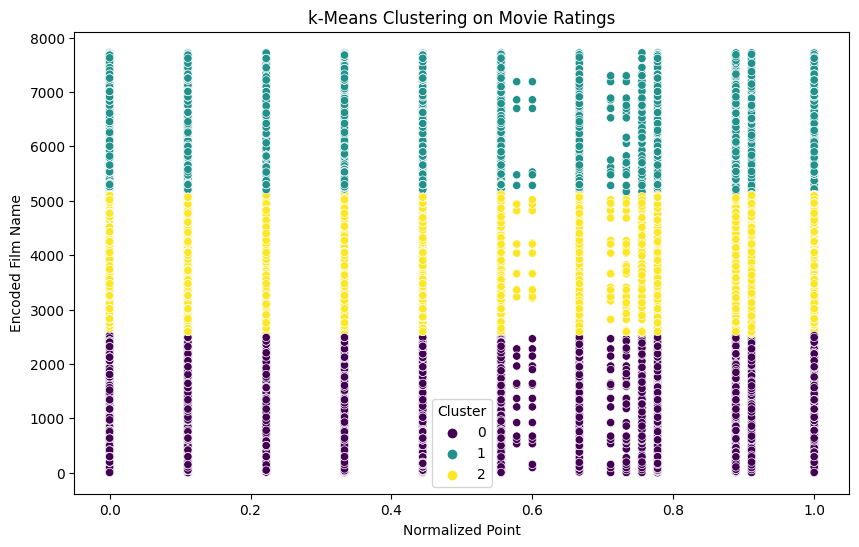

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='point', y='film_name', hue='kmeans_cluster', palette='viridis', data=df)
plt.title('k-Means Clustering on Movie Ratings')
plt.xlabel('Normalized Point')
plt.ylabel('Encoded Film Name')
plt.legend(title='Cluster')
plt.show()

k-Means kümeleme sonuçlarını görselleştirmek için bir dağılım grafiği (scatter plot) oluşturdum.

In [17]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(X)

if len(df[df['dbscan_cluster'] != -1]) > 0:
    dbscan_silhouette = silhouette_score(X[df['dbscan_cluster'] != -1], df['dbscan_cluster'][df['dbscan_cluster'] != -1])
else:
    dbscan_silhouette = -1
print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')

DBSCAN Silhouette Score: 0.8896239303174099


DBSCAN modelini fit edip, silhouette skorunu hesapladım. Gürültü noktalarını hariç tutarak skoru hesapladım.

**Gürültü noktaları**, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algoritmasının tespit ettiği ve kümeler içinde yer almayan verilerdir. Bu noktalar, diğer noktalarla yeterli yoğunlukta bir bağ kuramadıkları için kümelerden dışlanırlar.

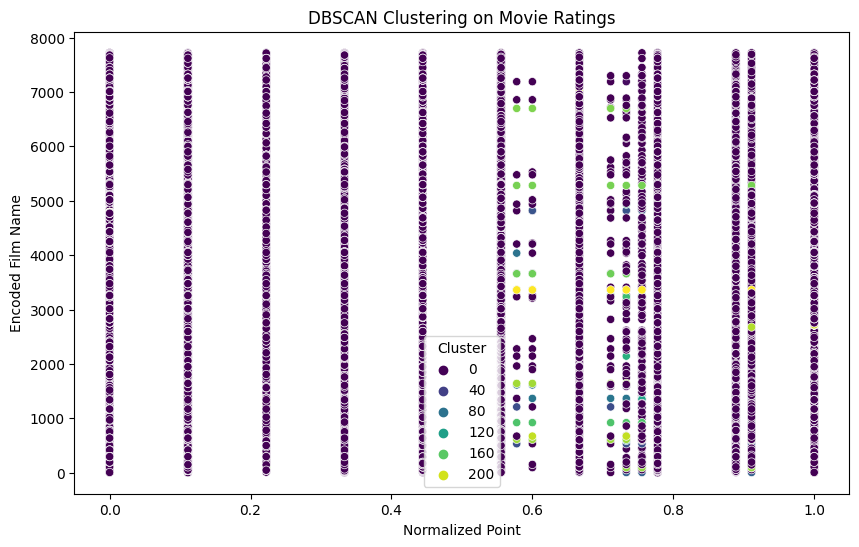

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='point', y='film_name', hue='dbscan_cluster', palette='viridis', data=df)
plt.title('DBSCAN Clustering on Movie Ratings')
plt.xlabel('Normalized Point')
plt.ylabel('Encoded Film Name')
plt.legend(title='Cluster')
plt.show()

DBSCAN kümeleme sonuçlarını görselleştirmek için bir dağılım grafiği (scatter plot) oluşturdum.

In [19]:
print("Gözetimli Modellerin Performansları:")
print(f'Lojistik Regresyon Doğruluk: {log_reg_accuracy}')
print(f'KNN Doğruluk: {knn_accuracy}')

print("\nGözetimsiz Modellerin Performansları:")
print(f'K-Means Silhouette Skoru: {kmeans_silhouette}')
print(f'DBSCAN Silhouette Skoru: {dbscan_silhouette}')


Gözetimli Modellerin Performansları:
Lojistik Regresyon Doğruluk: 0.9933317313468701
KNN Doğruluk: 0.7156073531178662

Gözetimsiz Modellerin Performansları:
K-Means Silhouette Skoru: 0.5927344471899542
DBSCAN Silhouette Skoru: 0.8896239303174099


Gözetimli ve gözetimsiz modellerin performanslarını accuracy ve silhouette skorlarını baz alarak kendi içlerinde kıyasladım.

**Accuracy (Doğruluk):** Gözetimli öğrenme modellerinde kullanılan bir performans metriğidir. Modelin doğru tahmin ettiği örneklerin, toplam tahmin sayısına oranıdır.

# Algoritma Seçimi & Hiperparametre Optimizasyon & Model Değerlendirme

In [20]:
best_model = None
param_grid = {}

if knn_accuracy > log_reg_accuracy:
    print("En iyi performansı gösteren gözetimli model: KNN")
    best_model = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'p': [1, 2]
    }
else:
    print("En iyi performansı gösteren gözetimli model: Lojistik Regresyon")
    best_model = LogisticRegression(max_iter=1000)
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    }

if kmeans_silhouette > dbscan_silhouette:
    best_unsupervised_model = 'KMeans'
else:
    best_unsupervised_model = 'DBSCAN'

print(f'En iyi gözetimsiz model: {best_unsupervised_model}')

if best_model:
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(f'Best Parameters for Supervised Model: {grid_search.best_params_}')

    optimized_model = grid_search.best_estimator_

    y_pred = optimized_model.predict(X_test)
    print('Optimized Supervised Model Classification Report:\n', classification_report(y_test, y_pred))
    print('Confusion Matrix for Optimized Supervised Model:\n', confusion_matrix(y_test, y_pred))
    print('Accuracy Score for Optimized Supervised Model:', accuracy_score(y_test, y_pred))
else:
    print("Gözetimsiz model kullanılarak hiperparametre optimizasyonu yapılmaz.")

En iyi performansı gösteren gözetimli model: Lojistik Regresyon
En iyi gözetimsiz model: DBSCAN
Best Parameters for Supervised Model: {'C': 10, 'solver': 'lbfgs'}
Optimized Supervised Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2405
           1       1.00      0.99      0.99      5615
           2       0.99      1.00      1.00      8626

    accuracy                           1.00     16646
   macro avg       1.00      1.00      1.00     16646
weighted avg       1.00      1.00      1.00     16646

Confusion Matrix for Optimized Supervised Model:
 [[2404    1    0]
 [   3 5560   52]
 [   0    0 8626]]
Accuracy Score for Optimized Supervised Model: 0.9966358284272497


Gözetimli ve gözetimsiz modeller arasında en iyi performansı gösteren modeli seçip, gözetimli model için hiperparametre optimizasyonu yaptım.

**En İyi Gözetimli Model Seçimi:**

**KNN ve Lojistik Regresyon Karşılaştırması:** *knn_accuracy* ve *log_reg_accuracy* değerlerini karşılaştırarak en iyi performansı gösteren gözetimli modeli seçtim.

Eğer KNN daha iyi performans gösteriyorsa, *best_model* olarak *KNeighborsClassifier()* belirledim ve hiperparametreleri *param_grid* içine koydum.

Eğer Lojistik Regresyon daha iyi performans gösteriyorsa, *best_model* olarak *LogisticRegression(max_iter=1000)* belirledim ve hiperparametreleri *param_grid* içine koydum.

**En İyi Gözetimsiz Model Seçimi:**

**K-Means ve DBSCAN Karşılaştırması:** *kmeans_silhouette* ve *dbscan_silhouette* değerlerini karşılaştırarak en iyi performansı gösteren gözetimsiz modeli seçtim.

En yüksek silhouette skoruna sahip model *best_unsupervised_model* olarak belirlenir.

**Hiperparametre Optimizasyonu:**

Seçilen gözetimli model için hiperparametre optimizasyonu *GridSearchCV* kullanarak yaptım. Bu, modelin en iyi hiperparametre kombinasyonunu bulmak için *çapraz doğrulama (cross-validation)* yapar.
*grid_search.fit(X_train, y_train)* ile model eğitilir ve en iyi hiperparametreler *grid_search.best_params_* ile elde edilir.

**Model Değerlendirme:**

En iyi hiperparametrelerle optimize edilmiş model (optimized_model) test verileri (X_test) üzerinde tahminler yaptım.

classification_report, confusion_matrix, ve accuracy_score kullanılarak modelin performansını değerlendirip ve sonuçları ekrana yazdırdım.